# Initialization & Setup

In [1]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cpu



In [4]:
data_path = '/content/drive/MyDrive/biomedicine/embedded_data/'

# Hyper- and Controlparameter

In [5]:
# Controlparameter

LOAD_FROM_DRIVE = False
SAVE_TO_DRIVE = True

In [6]:
# HYPERPARAMETER

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# Custom Dataset & Data Preparation

In [7]:
label_map = {
    'control': 0,
    'mild/moderate': 1,
    'severe/critical': 2,
    'progression': 1,
    'convalescence': 2,
}

In [8]:
class EmbeddedDataset(Dataset):
    def __init__(self, pkl_file, minimum=0, maximum=0, n_samples=0):
        self.data = pd.read_pickle(pkl_file)
        self.minimum = minimum
        self.downsample_labels()
        if maximum > 0:
            if n_samples > 0:
                raise Exception("Illegal to specify maximum and total number of samples. Might lead to impossible configuration")
            self.downsample_celltypes_maximum(maximum)
        if minimum > 0:
            self.enforce_minimum()
            if n_samples > 0:
                self.enforce_number_of_samples(n_samples, self.minimum)
                self.find_equal_distribution_with_number_of_samples(len(self.cell_types_list()), n_samples)
        elif n_samples > 0:
            raise Exception("Illegal to specify number of samples without a minimum. How are we supposed to know what kind of distribution you want?")
        print(self.data.head())

    def labels_severity_list(self):
        return list(pd.unique(self.data['severity']))

    def labels_state_list(self):
        return list(pd.unique(self.data['Sample time']))

    def cell_types_list(self):
        return list(pd.unique(self.data['celltype']))

    def distribution_cell_types(self):
        return self.data['celltype'].value_counts()

    def distribution_labels_severity(self):
        return self.data['severity'].value_counts()

    def distribution_labels_state(self):
        return self.data['Sample time'].value_counts()

    def find_equal_distribution_with_number_of_samples(self, n_celltypes, n_samples):
        """Recursively finds a fitting distribution for the specified number of samples and minimum number of samples per celltype"""
        if n_celltypes == 0:
            raise Exception(f"Could not find a valid data distribution for your combination of n_samples ({n_samples}) and minimum ({self.minimum}). \n Consider decreasing one or both of them to get a valid distribution.")
        nth_celltype_count = self.distribution_cell_types().iloc[n_celltypes-1]
        if(nth_celltype_count * n_celltypes > n_samples):
            self.downsample_celltypes_total(n_celltypes, n_samples)
        else:
            self.find_equal_distribution_with_number_of_samples(n_celltypes-1, n_samples)

    def enforce_minimum(self):
        """Cut all celltypes that does not have at least minimum samples"""
        minimum_fulfilling_celltypes = self.distribution_cell_types()[self.distribution_cell_types() >= self.minimum].index
        self.data = self.data[self.data['celltype'].isin(minimum_fulfilling_celltypes)]

    def enforce_number_of_samples(self, n_samples, minimum):
        """Truncate the celltypes to a number of celltypes that suffice to reach the number of samples, while providing the minimum number of samples per celltype.
        Always prefer celltypes with more counts over celltypes with less counts."""
        n_celltypes = min((n_samples // minimum), len(self.cell_types_list()))
        self.data = self.data[self.data['celltype'].isin(self.distribution_cell_types().iloc[:n_celltypes].index)]

    def downsample_labels(self):
        """Downsamples the data to achieve equal label distribution for severity within each cell type"""
        cell_types = self.cell_types_list()
        downsampled_data = pd.DataFrame()
        for cell_type in cell_types:
            cell_type_data = self.data[self.data['celltype'] == cell_type]
            labels = cell_type_data['severity'].value_counts().index
            if len(labels) < len(self.labels_severity_list()):
                print(f"Cut cell type {cell_type} because it only has the following labels: {labels}")
                continue
            min_count = cell_type_data['severity'].value_counts().min()
            sampled_data = pd.DataFrame()
            for label in labels:
                label_data = cell_type_data[cell_type_data['severity'] == label]
                sampled_label_data = label_data.sample(n=min_count, random_state=42)
                sampled_data = pd.concat([sampled_data, sampled_label_data])
            downsampled_data = pd.concat([downsampled_data, sampled_data])
        self.data = downsampled_data

    def downsample_celltypes_total(self, n_celltypes, n_samples):
        """Downsamples the data to achieve equal celltype distribution while providing the specified number of total samples"""
        n = n_samples // n_celltypes
        valid_celltypes = self.distribution_cell_types().iloc[:n_celltypes].index
        downsampled_data = pd.DataFrame()
        for i, cell_type in enumerate(valid_celltypes):
            cell_type_data = self.data[self.data['celltype'] == cell_type]
            labels = cell_type_data['severity'].value_counts().index
            sampled_data = pd.DataFrame()
            if i < n_samples - (n * n_celltypes):
                celltype_n = n + 1
            else:
                celltype_n = n

            label_n = celltype_n // len(labels)
            for j, label in enumerate(labels):
                label_data = cell_type_data[cell_type_data['severity'] == label]
                if j < celltype_n - (label_n * len(labels)):
                    sampled_label_data = label_data.sample(n=label_n + 1, random_state=42)
                else:
                    sampled_label_data = label_data.sample(n=label_n, random_state=42)
                sampled_data = pd.concat([sampled_data, sampled_label_data])
            downsampled_data = pd.concat([downsampled_data, sampled_data])
        self.data = downsampled_data
        sample_sum = sum([x for x in self.data['celltype'].value_counts().values])
        print(f"\nSum of samples: {sample_sum}")
        print(f"Number of celltypes: {len(self.data['celltype'].value_counts())}")

    def downsample_celltypes_maximum(self, maximum):
        """Downsamples the data of each cell type to a maximum number of samples, while maintaining equal label distribution"""
        n = maximum // len(self.labels_severity_list())
        downsampled_data = pd.DataFrame()
        for i, cell_type in enumerate(self.cell_types_list()):
            cell_type_data = self.data[self.data['celltype'] == cell_type]
            if len(cell_type_data) < maximum:
                downsampled_data = pd.concat([downsampled_data, cell_type_data])
                continue
            sampled_data = pd.DataFrame()
            for j, label in enumerate(self.labels_severity_list()):
                label_data = cell_type_data[cell_type_data['severity'] == label]
                if j < maximum - (n * len(self.labels_severity_list())):
                    sampled_label_data = label_data.sample(n=n+1, random_state=42)
                else:
                    sampled_label_data = label_data.sample(n=n, random_state=42)
                sampled_data = pd.concat([sampled_data, sampled_label_data])
            downsampled_data = pd.concat([downsampled_data, sampled_data])
        self.data = downsampled_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)
        label_state = torch.tensor(label_map.get(self.data.iloc[idx, 1]), dtype=torch.long)
        label_severity = torch.tensor(label_map.get(self.data.iloc[idx, 3]), dtype=torch.long)
        cell_type = self.data.iloc[idx, 2]

        return embeddings, label_severity, label_state, cell_type

## Data Distribution

In [9]:
TOTAL_NUMBER_OF_SAMPLES = 90 * 1000
MINIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE = 500
MAXIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE = 3000

In [10]:
dataset = EmbeddedDataset(
    os.path.join(data_path, 'embedded_data_split_severity_celltype_progression_all.pkl'),
    minimum=MINIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE,
    maximum=MAXIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE,
    # n_samples=TOTAL_NUMBER_OF_SAMPLES
)


Cut cell type Macro_c4-DNAJB1 because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type Epi-Ciliated because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type DC_c3-LAMP3 because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type Epi-Squamous because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type Macro_c3-EREG because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type Epi-Secretory because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='object', name='severity')
Cut cell type Neu_c4-RSAD2 because it only has the following labels: Index(['severe/critical', 'mild/moderate'], dtype='

In [11]:
dataset.distribution_cell_types()

,count
celltype,
Mono_c2-CD14-HLA-DPB1,3000
T_CD4_c06-NR4A2,3000
T_CD4_c05-FOS,3000
T_CD4_c09-GZMK-FOS_l,3000
T_CD8_c09-SLC4A10,3000
DC_c2-CD1C,3000
T_CD8_c06-TNF,3000
NK_c01-FCGR3A,3000
T_CD8_c03-GZMK,3000


In [12]:
print(f"Number of different celltypes: {len(dataset.cell_types_list())}")

Number of different celltypes: 37


In [13]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Architecture


In [15]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
# Training Loop
def train(model, train_loader, num_epochs, optimizer, criterion):
    model.to(device)  # Move model to device ONCE
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (embeddings, severity_labels, state_labels, celltype) in enumerate(dataloader):
            embeddings = embeddings.to(device)
            severity_labels = severity_labels.to(device).long()  # Labels: 0=Control, 1=Mild, 2=Severe
            state_labels = state_labels.to(device).long()  # Labels: 0=Control, 1=Progression, 2=Convalescence

            optimizer.zero_grad()
            output = model(embeddings)  # Get raw logits

            loss = criterion(output, severity_labels)  # Compute loss, change the labels depending on which labels you want to predict
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            dataloader.set_postfix({"Loss": running_loss / (i + 1)})  # Show average loss per batch


In [17]:
# directory paths to google drive for model saving and retrieving

directory_path = 'content/MyDrive/biomedicine/models/classifier'

model_path = os.path.join(directory_path, f"classifier_model_{TOTAL_NUMBER_OF_SAMPLES}_{TOTAL_NUMBER_OF_SAMPLES}.pth")

print(model_path)

content/MyDrive/biomedicine/models/classifier/classifier_model_90000_90000.pth


In [18]:
# Initialize the model

model = Classifier().to(device)

if LOAD_FROM_DRIVE:
    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
        print("Model loaded from drive")
    except Exception as e:
        print(f"Error loading model from drive: {e}")

# set up loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training

In [19]:
# start training loop
if not LOAD_FROM_DRIVE:
    train(
        model=model,
        train_loader=train_loader,
        num_epochs=NUM_EPOCHS,
        optimizer=optimizer,
        criterion=criterion
    )

Epoch 10/10: 100%|██████████| 629/629 [03:00<00:00,  3.48it/s, Loss=0.685]


In [20]:
# save to drive

if SAVE_TO_DRIVE:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

    torch.save(model.state_dict(), model_path)
    print("Model saved to drive")

Model saved to drive


# Evaluation

In [21]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import numpy as np

def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    cell_type_results = defaultdict(lambda: {"y_true": [], "y_pred": []})  # Store results per cell type

    with torch.no_grad():
        for embeddings, severity_labels, state_labels, cell_types in test_loader:
            embeddings = embeddings.to(device)
            severity_labels = severity_labels.to(device).long()  # Labels: 0=Control, 1=Mild, 2=Severe
            state_labels = state_labels.to(device).long()  # Labels: 0=Control, 1=Progression, 2=Convalescence
            labels = severity_labels # change depending on which output you want to evaluate

            outputs = model(embeddings).squeeze()
            preds = torch.argmax(outputs, dim=1)  # Convert probabilities to predicted labels

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store results for each cell type
            for i, cell in enumerate(cell_types):
                cell_type_results[cell]["y_true"].append(labels[i].item())
                cell_type_results[cell]["y_pred"].append(preds[i].item())

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1_overall = f1_score(all_labels, all_preds, average="macro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["control", "mild/moderate", "severe/critical"], yticklabels=["control", "mild/moderate", "severe/critical"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute metrics per cell type
    cell_type_list, acc_list, f1_list, prec_list, rec_list = [], [], [], [], []
    for cell, values in cell_type_results.items():
        acc = accuracy_score(values["y_true"], values["y_pred"])
        prec = precision_score(values["y_true"], values["y_pred"], average="macro")
        rec = recall_score(values["y_true"], values["y_pred"], average="macro")
        f1 = f1_score(values["y_true"], values["y_pred"], average="macro")

        cell_type_list.append(cell)
        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

    cell_type_results_df = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy": acc_list,
        "F1-score": f1_list,
        "Precision": prec_list,
        "Recall": rec_list
    })

    return accuracy, precision, recall, f1_overall, cell_type_results_df


In [22]:
import pandas as pd
from collections import Counter

def compare_cell_type_distribution(dataset, train_loader, test_loader):
    # Get total distribution from dataset (assuming it's a DataFrame)
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Total Count"]

    # Initialize counters for train and test sets
    train_counter = Counter()
    test_counter = Counter()

    # Count occurrences of each cell type in training set
    for _, _, _, cell_types in train_loader:
        train_counter.update(cell_types)

    # Count occurrences of each cell type in test set
    for _, _, _, cell_types in test_loader:
        test_counter.update(cell_types)

    # Convert counters to Pandas Series
    train_series = pd.Series(train_counter, name="Train Count")
    test_series = pd.Series(test_counter, name="Test Count")

    # Create a DataFrame with all distributions
    df = total_distribution.set_index("Cell Type").join([train_series, test_series]).fillna(0)

    # Convert counts to integers
    df = df.astype(int)

    # Print the table
   # print(df)

    return df


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_correlation(dataset, train_loader, test_loader, model):
    # Step 1: Get dataset distribution
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Train Count"]

    # Step 2: Evaluate model performance per cell type
    _, _, _, _, cell_results = evaluate(model, test_loader)
    """
    # Step 3: Ensure cell_results is properly structured
    if isinstance(cell_results, dict):
        performance_data = []
        for cell_type, metrics in cell_results.items():
            if isinstance(metrics, dict):  # Ensure it's not a string or number
                row = {"Cell Type": cell_type}
                row.update(metrics)  # Add accuracy, F1-score, etc.
                performance_data.append(row)
        performance_df = pd.DataFrame(performance_data)
    else:
        raise ValueError("cell_results is not a valid dictionary.")
    """
    # Step 4: Merge both DataFrames
    merged_df = total_distribution.merge(cell_results, on="Cell Type", how="inner")

    # Step 5: Compute correlation
    correlation_results = {
        "Accuracy": pearsonr(merged_df["Train Count"], merged_df["Accuracy"])[0],
        "F1-score": pearsonr(merged_df["Train Count"], merged_df["F1-score"])[0]
    }

    # Step 6: Visualization
    plt.figure(figsize=(12, 5))

    # Scatter Plot: Frequency vs Accuracy
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy")
    plt.title(f"Correlation: {correlation_results['Accuracy']:.4f}")

    # Scatter Plot: Frequency vs F1-score
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score")
    plt.title(f"Correlation: {correlation_results['F1-score']:.4f}")

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print("Correlation between Cell Type Frequency and Performance:")
    print(f"  Accuracy Correlation: {correlation_results['Accuracy']:.4f}")
    print(f"  F1-score Correlation: {correlation_results['F1-score']:.4f}")

    return merged_df, correlation_results


In [24]:
# df_analysis, correlation = analyze_correlation(dataset, train_loader, test_loader, model)

## Results

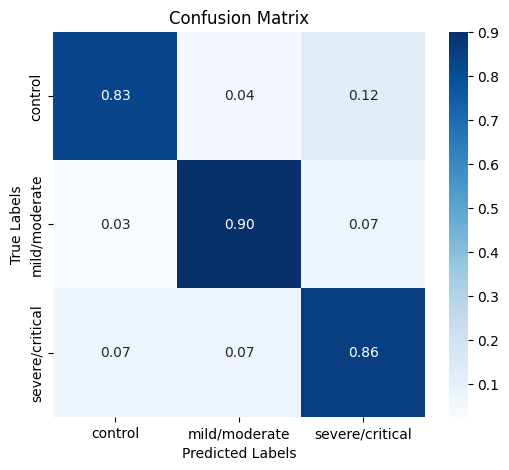

F1-score: 0.861
Accuracy: 0.859


In [25]:
accuracy, precision, recall, f1, cell_type_results_df = evaluate(model, test_loader)
# print(cell_type_results_df)
print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

In [26]:
df_sorted = cell_type_results_df.sort_values(by='F1-score', ascending=False)
print(df_sorted.head())
print()
print(df_sorted.tail())

                Cell Type  Accuracy  F1-score  Precision    Recall
1    T_CD4_c09-GZMK-FOS_l  0.912397  0.912959   0.912816  0.913158
26        T_CD4_c04-ANXA2  0.902521  0.905443   0.902265  0.909485
35      Mono_c4-CD14-CD16  0.904639  0.903599   0.908747  0.902906
9   Mono_c2-CD14-HLA-DPB1  0.891026  0.893483   0.894036  0.894721
2         T_CD4_c12-FOXP3  0.889070  0.891899   0.889138  0.895857

           Cell Type  Accuracy  F1-score  Precision    Recall
3   B_c02-MS4A1-CD27  0.817447  0.812841   0.810399  0.818200
21   B_c03-CD27-AIM2  0.847934  0.807677   0.827583  0.793430
34       B_c01-TCL1A  0.826758  0.806096   0.818096  0.797927
31   B_c05-MZB1-XBP1  0.710227  0.711809   0.714415  0.711332
12              Mega  0.724670  0.604100   0.814697  0.610245


In [27]:
compare_cell_type_distribution(dataset, train_loader, test_loader)


,Total Count,Train Count,Test Count
Cell Type,,,
Mono_c2-CD14-HLA-DPB1,3000,2376,624
T_CD4_c06-NR4A2,3000,2388,612
T_CD4_c05-FOS,3000,2397,603
T_CD4_c09-GZMK-FOS_l,3000,2395,605
T_CD8_c09-SLC4A10,3000,2405,595
DC_c2-CD1C,3000,2390,610
T_CD8_c06-TNF,3000,2435,565
NK_c01-FCGR3A,3000,2411,589
T_CD8_c03-GZMK,3000,2401,599
